In [1]:
%load_ext autoreload
%autoreload 2
import flimview.flim as flim
import flimview.read_utils as ru
import flimview.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm

In [2]:
sdtfile = 'Psoriasis/test_dataset/FLIM_D/60_D_760nm_c11.sdt'

In [3]:
data,header = ru.read_sdt_file(sdtfile)

In [4]:
c11 = flim.FlimCube(data, header)

In [11]:
c11.show_header()

---------------------
sdt_info: *IDENTIFICATION
  ID        : SPC FCS Data File
  Title     : 60_D_760nm_c11
  Version   : 3  966 M
  Revision  : 8 bits ADC
  Date      : 2018-12-18
  Time      : 11:12:26
  Author    : System
  Company   : Unknown
  Contents  : Autosaved results for cycle 11 of 40 from FIFO_IMAGE measurement
*END


xpix: 256
ypix: 256
tpix: 256
tresolution: 48.86091184430619
---------------------------
Data Shape: (256, 256, 256)
Time resolution [ps]: 48.86091184430619
---------------------------


In [12]:
np.max(c11.data, axis=2).shape

(256, 256)

In [13]:
c11.mask_peak(0)

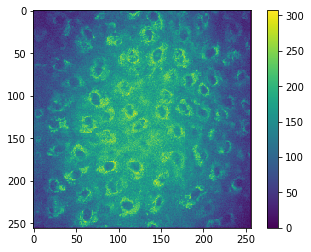

In [14]:
plt.imshow(c11.intensity)
plt.colorbar()

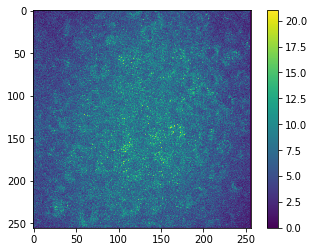

In [15]:
plt.imshow(c11.peak)
plt.colorbar()

In [16]:
c11_bin = flim.binCube(c11, bin=4, kernel='mean')

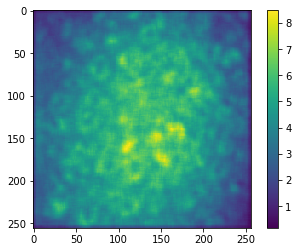

In [17]:
plt.imshow(c11_bin.peak)
plt.colorbar()

In [18]:
c11.mask_peak(5)
c11_bin.mask_peak(0, mask=c11.mask)
#c11_bin.mask_peak(5)

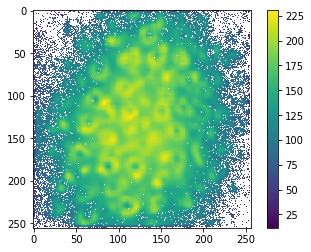

In [19]:
plt.imshow(c11_bin.intensity)
plt.colorbar()

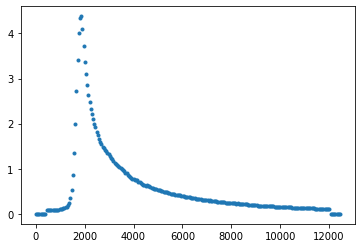

In [20]:
plt.plot(*flim.meanDecay(c11_bin), '.')

In [21]:
x,y = flim.meanDecay(c11_bin)
x /= 1000 # to ns
x = x[10:240]
y = y[10:240]

In [22]:
mymodel = models.model1
xf,yf, pfit, pcov, chi2 = flim.fitPixel(x,y, model=mymodel, initial_p=[0.8, 0.3, 3, 0.03], bounds=(0,np.inf), norm=True)

In [23]:
vd = flim.getModelVars(mymodel)

In [24]:
print(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=False))

model1 (chi2 = 0.034): 
a1    = 0.575 ± 0.004
tau1  = 0.298 ± 0.004
tau2  = 2.154 ± 0.030
level = 0.026 ± 0.001


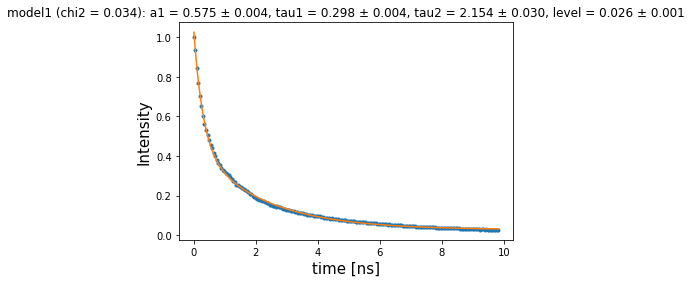

In [25]:
plt.plot(xf,yf,'.')
plt.plot(xf,mymodel(xf, *pfit))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
_=plt.title(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=True))

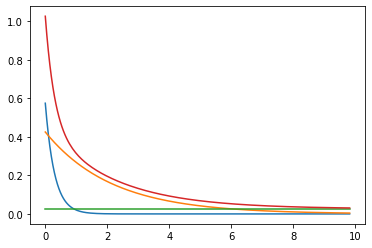

In [26]:
y1 = pfit[0]*np.exp(-xf/pfit[1])
y2 = (1-pfit[0])*np.exp(-xf/pfit[2])
y3 = np.zeros(len(xf))+ pfit[3]
plt.plot(xf, y1)

plt.plot(xf, y2)
plt.plot(xf, y3)
plt.plot(xf, y1+y2+y3)

230 230


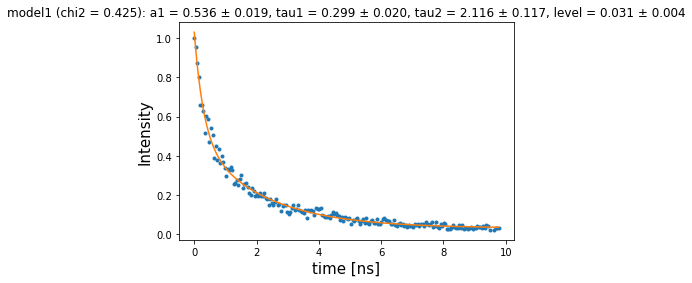

In [27]:
px = 130
py = 130
bounds0=[0.0, 0.0, 0. , 0.]
bounds1=[1, 1., 5., 1.]
y = c11_bin.data[px,py,10:240]
print(len(x), len(y))
xf,yf,pfit_i,pcov_i,chi2_i = flim.fitPixel(x,y,initial_p=pfit, model=mymodel, bounds=(bounds0, bounds1), norm=True, threshold=0.02) #bounds=(pfit-10*delta,pfit+10*delta))
plt.plot(xf,yf,'.')
plt.plot(xf,mymodel(xf, *pfit_i))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
_=plt.title(flim.printModel(mymodel, pfit_i, pcov_i, chi2_i, oneliner=True))
#plt.savefig('test.png')

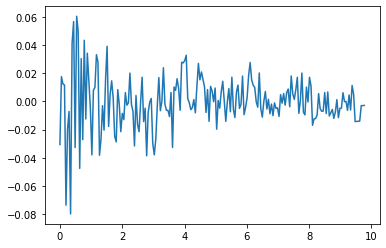

In [29]:
plt.plot(xf,(yf-mymodel(xf, *pfit_i)))

In [30]:
np.mean(yf-mymodel(xf, *pfit_i))

1.6862534228033069e-10

(array([ 2.,  0.,  0.,  0.,  1.,  4.,  3.,  7.,  7., 19., 48., 31., 35.,
        20.,  6.,  7.,  4.,  2.,  1.,  2.]),
 array([-0.07990357, -0.0728821 , -0.06586063, -0.05883915, -0.05181768,
        -0.04479621, -0.03777473, -0.03075326, -0.02373179, -0.01671031,
        -0.00968884, -0.00266737,  0.00435411,  0.01137558,  0.01839705,
         0.02541852,  0.03244   ,  0.03946147,  0.04648294,  0.05350442,
         0.06052589]),
 <a list of 20 Patch objects>)

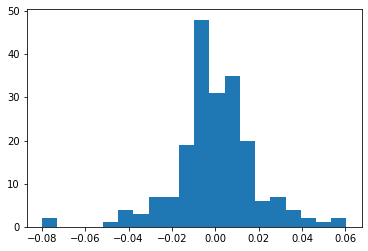

In [31]:
plt.hist(yf-mymodel(xf, *pfit_i),bins=20)

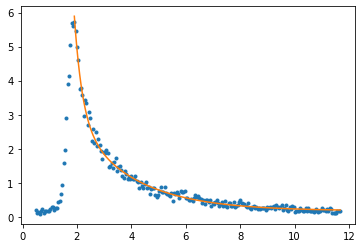

In [32]:
plt.plot(x,y,'.')
plt.plot(xf+x[np.argmax(y)],mymodel(xf, *pfit_i)*np.max(y))

In [33]:
PP = np.zeros((256,256,2,len(pfit)+1))-1
np.shape(PP)

(256, 256, 2, 5)

In [507]:
failed = np.zeros((256,256))
for i in tqdm(range(256)):
    for j in range(256):
        if c11_bin.mask[i,j]:
            continue
        try:
            y = c11_bin.data[i,j,10:240]
            xf,yf,pfit_i,pcov_i,chi2_i = flim.fitPixel(x,y,initial_p=pfit, model=mymodel, bounds=(bounds0, bounds1), norm=True, threshold=0.02 )
            for k in range(len(pfit)):
                PP[i,j,0,k] = pfit_i[k]
                PP[i,j,1,k] = np.sqrt(np.diag(pcov_i)[k])
            PP[i,j,0,-1] = chi2_i
        except:
            failed[i,j] = 1

100%|██████████| 256/256 [04:50<00:00,  1.31it/s]


In [508]:
vd

{'parameters': ['a1', 'tau1', 'tau2', 'level'], 'name': 'model1'}

In [509]:
a1 = np.ma.masked_array(PP[:,:,0,0], mask=c11_bin.mask)
tau1 = np.ma.masked_array(PP[:,:,0,1], mask=c11_bin.mask)
tau2 = np.ma.masked_array(PP[:,:,0,2], mask=c11_bin.mask)
level = np.ma.masked_array(PP[:,:,0,3], mask=c11_bin.mask)
chi2 = np.ma.masked_array(PP[:,:,0,4], mask=c11_bin.mask)
del PP

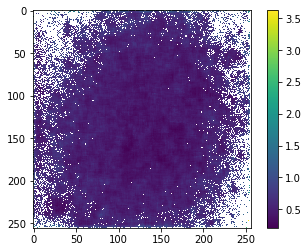

In [510]:
plt.imshow(chi2)
plt.colorbar()

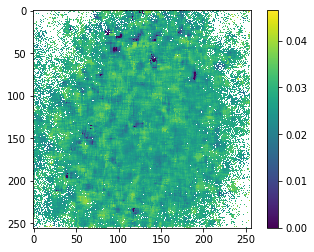

In [511]:
plt.imshow(level)
plt.colorbar()

In [512]:
np.mean(tau1),np.mean(tau2)

(2.1055892420005216, 0.30474703849587037)

In [513]:
chi2.compressed().shape

(54353,)

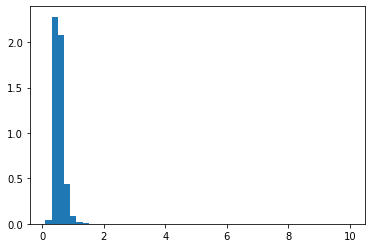

In [514]:
_=plt.hist(chi2.compressed(),bins=np.linspace(0.1,10,50), density=True)

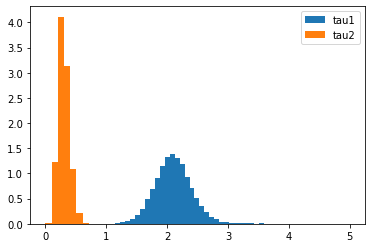

In [515]:
_=plt.hist(tau1.compressed(),bins=np.linspace(0,4,50), density=True, label='tau1')
_=plt.hist(tau2.compressed(),bins=np.linspace(0,5,50), density=True, label='tau2')
plt.legend(loc=0)

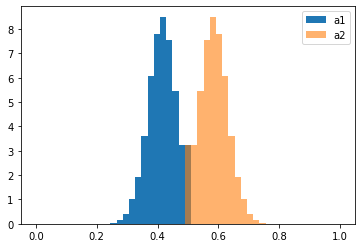

In [516]:
_=plt.hist(a1.compressed(),bins=np.linspace(0,1,50), density=True, label='a1')
_=plt.hist((1-a1).compressed(),bins=np.linspace(0,1,50), density=True, alpha=.6, label='a2')
plt.legend(loc=0)

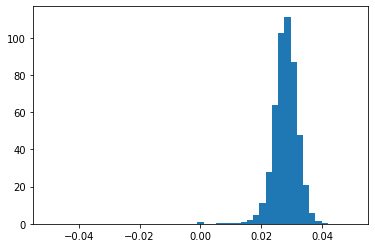

In [517]:
_=plt.hist(level.compressed(),bins=np.linspace(-.05,0.05,50), density=True)

In [518]:
chi2[130,130]

0.4252064631262711

In [519]:
pfit

array([0.42529056, 2.15408369, 0.29778871, 0.0264065 ])

In [520]:
delta=np.sqrt(np.diag(pcov))

In [521]:
pfit-delta*5

array([0.40321469, 2.00517194, 0.27674673, 0.02232696])

In [522]:
t1f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_t1.asc'
text_file = open(t1f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
t1data=lines4

In [523]:
t2f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_t2.asc'
text_file = open(t2f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
t2data=lines4

In [524]:
a1f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a1.asc'
text_file = open(a1f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a1data=lines4

In [525]:
a2f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a2.asc'
text_file = open(a2f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a2data=lines4

In [526]:
a1p = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a1p.asc'
text_file = open(a1p, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a1pdata=lines4

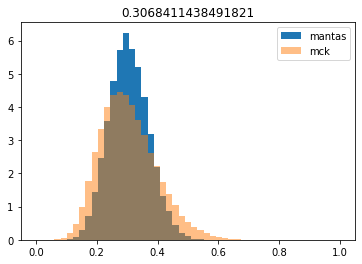

In [527]:
_=plt.hist(t1data.flatten()/1000.,bins=np.linspace(0,1,50), density=True,label='mantas')
#=plt.hist(t2data.flatten(),bins=np.linspace(0,3500,50), density=True)
_=plt.hist(tau2.compressed(),bins=np.linspace(0,1,50), density=True,alpha=0.5,label='mck')
#_=plt.hist(tau1m.flatten()*1000,bins=np.linspace(-1000,2000,50), density=True,alpha=0.5,label='mck_masked')
plt.legend(loc=0)
_=plt.title(np.mean(t1data.flatten()/1000.))

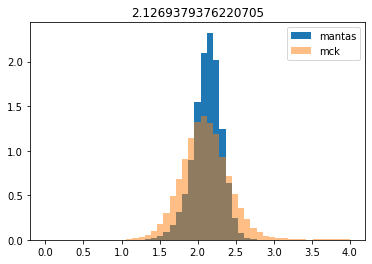

In [528]:
_=plt.hist(t2data.flatten()/1000.,bins=np.linspace(0,4,50), density=True, label='mantas')
#_=plt.hist(t2data.flatten(),bins=np.linspace(0,3500,50), density=True)
_=plt.hist(tau1.compressed(),bins=np.linspace(0,4,50), density=True,alpha=0.5, label='mck')
_=plt.title(np.mean(t2data.flatten()/1000.))
plt.legend(loc=0)


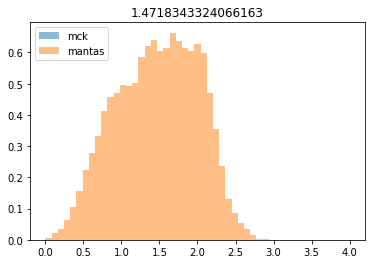

In [529]:
_=plt.hist(a1.compressed(),bins=np.linspace(0.5,4,50), density=True,alpha=0.5,label='mck')
_=plt.hist(a2data.flatten()/100.,bins=np.linspace(0,4,50), density=True,alpha=0.5,label='mantas')
plt.legend(loc=0)
_=plt.title(np.mean(a2data.flatten()/100.))

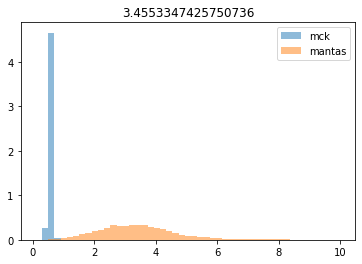

In [530]:
_=plt.hist((1-a1).compressed(),bins=np.linspace(0.1,10,50), density=True,alpha=0.5, label='mck')
_=plt.hist(a1data.flatten()/100.,bins=np.linspace(0.1,10,50), density=True,alpha=0.5, label='mantas')
_=plt.title(np.mean(a1data.flatten()/100.))
plt.legend(loc=0)

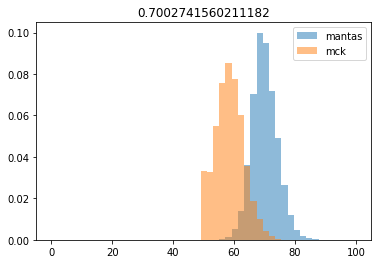

In [533]:
#_=plt.hist(a1[:,:,0].flatten(),bins=np.linspace(0.1,1000,50), density=True,alpha=0.5)
_=plt.hist(a1pdata.flatten(),bins=np.linspace(0.1,100,50), density=True,alpha=0.5, label='mantas')
_=plt.hist((1-a1).compressed()*100+0,bins=np.linspace(0.1,100,50), density=True,alpha=0.5, label='mck')
#_=plt.hist(level.compressed(),bins=np.linspace(0.1,2,50), density=True,alpha=0.5)
_=plt.title(np.mean(a1pdata.flatten()/100.))
plt.legend(loc=0)

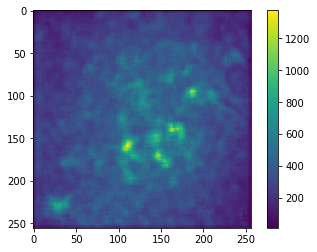

In [541]:
plt.imshow(a1data)
plt.colorbar()

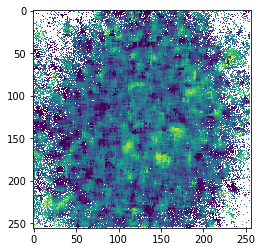

In [535]:
plt.imshow(1-a1)